In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, UpSampling2D, Dense, MaxPool2D, LeakyReLU, Reshape, Dropout, Flatten, GaussianNoise, Embedding, multiply, concatenate, add
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import time

In [3]:
def normalize_img(img):
    return (img - 127.5)/127.5

def unnormalize_img(img):
    return (img + 1.) / 2.

In [4]:
train_imgs = []
train_classes = []
class_index = 0
import os
for root, dirs, files in os.walk("./CUB_200_2011/CUB_200_2011/images-cleaned/", topdown=False):
    print(f'{len(files)} samples in class {class_index}, ({root})')
    for name in files:
        train_imgs.append(cv2.cvtColor(cv2.imread(os.path.join(root, name)), cv2.COLOR_RGB2BGR))
        train_classes.append(class_index)
    class_index += 1
train_imgs = np.array(train_imgs)
train_imgs = (train_imgs - 127.5)/127.5
train_imgs = train_imgs.astype(np.float32)
train_classes = np.array(train_classes)

60 samples in class 0, (./CUB_200_2011/CUB_200_2011/images-cleaned/001.Black_footed_Albatross)
60 samples in class 1, (./CUB_200_2011/CUB_200_2011/images-cleaned/002.Laysan_Albatross)
58 samples in class 2, (./CUB_200_2011/CUB_200_2011/images-cleaned/003.Sooty_Albatross)
60 samples in class 3, (./CUB_200_2011/CUB_200_2011/images-cleaned/004.Groove_billed_Ani)
44 samples in class 4, (./CUB_200_2011/CUB_200_2011/images-cleaned/005.Crested_Auklet)
41 samples in class 5, (./CUB_200_2011/CUB_200_2011/images-cleaned/006.Least_Auklet)
53 samples in class 6, (./CUB_200_2011/CUB_200_2011/images-cleaned/007.Parakeet_Auklet)
48 samples in class 7, (./CUB_200_2011/CUB_200_2011/images-cleaned/008.Rhinoceros_Auklet)
59 samples in class 8, (./CUB_200_2011/CUB_200_2011/images-cleaned/009.Brewer_Blackbird)
60 samples in class 9, (./CUB_200_2011/CUB_200_2011/images-cleaned/010.Red_winged_Blackbird)
60 samples in class 10, (./CUB_200_2011/CUB_200_2011/images-cleaned/011.Rusty_Blackbird)
56 samples in cla

60 samples in class 92, (./CUB_200_2011/CUB_200_2011/images-cleaned/093.Clark_Nutcracker)
60 samples in class 93, (./CUB_200_2011/CUB_200_2011/images-cleaned/094.White_breasted_Nuthatch)
60 samples in class 94, (./CUB_200_2011/CUB_200_2011/images-cleaned/095.Baltimore_Oriole)
60 samples in class 95, (./CUB_200_2011/CUB_200_2011/images-cleaned/096.Hooded_Oriole)
59 samples in class 96, (./CUB_200_2011/CUB_200_2011/images-cleaned/097.Orchard_Oriole)
60 samples in class 97, (./CUB_200_2011/CUB_200_2011/images-cleaned/098.Scott_Oriole)
60 samples in class 98, (./CUB_200_2011/CUB_200_2011/images-cleaned/099.Ovenbird)
60 samples in class 99, (./CUB_200_2011/CUB_200_2011/images-cleaned/100.Brown_Pelican)
50 samples in class 100, (./CUB_200_2011/CUB_200_2011/images-cleaned/101.White_Pelican)
60 samples in class 101, (./CUB_200_2011/CUB_200_2011/images-cleaned/102.Western_Wood_Pewee)
60 samples in class 102, (./CUB_200_2011/CUB_200_2011/images-cleaned/103.Sayornis)
60 samples in class 103, (./C

60 samples in class 187, (./CUB_200_2011/CUB_200_2011/images-cleaned/188.Pileated_Woodpecker)
60 samples in class 188, (./CUB_200_2011/CUB_200_2011/images-cleaned/189.Red_bellied_Woodpecker)
58 samples in class 189, (./CUB_200_2011/CUB_200_2011/images-cleaned/190.Red_cockaded_Woodpecker)
60 samples in class 190, (./CUB_200_2011/CUB_200_2011/images-cleaned/191.Red_headed_Woodpecker)
60 samples in class 191, (./CUB_200_2011/CUB_200_2011/images-cleaned/192.Downy_Woodpecker)
60 samples in class 192, (./CUB_200_2011/CUB_200_2011/images-cleaned/193.Bewick_Wren)
60 samples in class 193, (./CUB_200_2011/CUB_200_2011/images-cleaned/194.Cactus_Wren)
60 samples in class 194, (./CUB_200_2011/CUB_200_2011/images-cleaned/195.Carolina_Wren)
59 samples in class 195, (./CUB_200_2011/CUB_200_2011/images-cleaned/196.House_Wren)
60 samples in class 196, (./CUB_200_2011/CUB_200_2011/images-cleaned/197.Marsh_Wren)
60 samples in class 197, (./CUB_200_2011/CUB_200_2011/images-cleaned/198.Rock_Wren)
60 samples

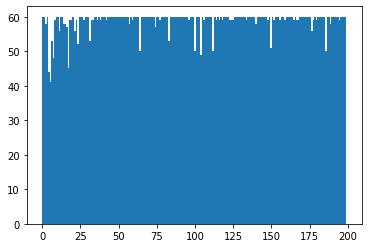

(11788, 64, 64, 3)


In [5]:
plt.hist(train_classes, bins=200)
plt.show()
assert(len(train_imgs) == len(train_classes))
print(train_imgs.shape)

In [6]:
def create_simple_attrs(attrs):
    # Structure is like so: [0-14:color, 15-19:size, 20-33:shape]

    simple_attrs = np.zeros((attrs.shape[0], 34))
    
    # Color
    simple_attrs[:, 0:15] = attrs[:, 248:263]
    
    # Size and shape
    simple_attrs[:, 15:34] = attrs[:, 217:236]
    
    return simple_attrs


In [110]:
def create_even_simpler_attrs(attrs):
    # Structure is like so: [0-4:color, 5-7:size, 8-9:shape]
    
    simplest_attrs = np.zeros((attrs.shape[0], 10))
    
    simplest_attrs[:, 0] = attrs[:, 1] # Brown
    simplest_attrs[:, 1] = attrs[:, 5] # Grey
    simplest_attrs[:, 2] = attrs[:, 11] # Black
    simplest_attrs[:, 3] = attrs[:, 12] # White
    simplest_attrs[:, 4] = np.clip(np.sum(attrs[:, [0, 2, 3, 4, 6, 7, 8, 9, 10, 13, 14]], axis=1), a_min=0, a_max=1) # Other
    
    simplest_attrs[:, 5] = attrs[:, 19] # Smallest
    simplest_attrs[:, 6] = attrs[:, 16] # Small
    simplest_attrs[:, 7] = np.clip(np.sum(attrs[:, [15, 17, 18]], axis=1), a_min=0, a_max=1) # Large
    
    simplest_attrs[:, 8] = attrs[:, 33] # Perching-like
    simplest_attrs[:, 9] = np.clip(np.sum(attrs[:, [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]], axis=1), a_min=0, a_max=1) # Not perching-like
    
    return simplest_attrs

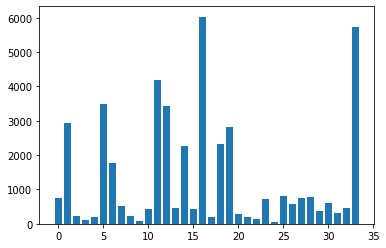

In [114]:
def load_image_attributes():
    train_attrs = np.zeros((train_imgs.shape[0], 312))
    with open('./CUB_200_2011/CUB_200_2011/attributes/image_attribute_labels.txt', 'r') as f:
        lines = f.readlines()
        for line in lines:
            
            # For now we don't care about attribute certainty, just if it is present.
            try:
                split = line.split()
                img_id = int(split[0])
                assert(img_id > 0)
                assert(img_id <= 11788)
                attr_id = int(split[1])
                assert(attr_id > 0)
                assert(attr_id <= 312)
                is_present = int(split[2])
                assert(is_present == 0 or is_present == 1)
            except: 
                print(line)
                print(line.split())
                return
            
            train_attrs[img_id-1, attr_id-1] = is_present
    return train_attrs

train_attrs = load_image_attributes().astype('float32')
train_attrs = create_simple_attrs(train_attrs)
plt.bar([x for x in range(34)], np.sum(train_attrs, axis=0))
plt.show()
train_attrs = create_even_simpler_attrs(train_attrs)
train_attrs = train_attrs.astype(np.float32)

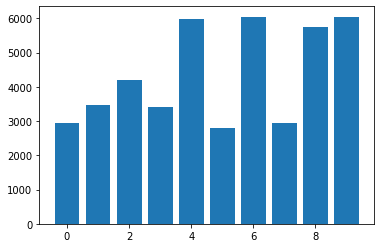

4358.4
1349.5349


In [115]:
plt.bar([x for x in range(10)], np.sum(train_attrs, axis=0))
plt.show()
sum_attrs = np.sum(train_attrs, axis=0)

print(np.mean(sum_attrs))
print(np.std(sum_attrs))
# np.argmin(sum_attrs)

In [119]:
def make_generator_model(shape):
    
    noise_in = Input(shape=shape)
    attributes_in = Input(shape=(10,))
    
    input_layer = concatenate([noise_in, attributes_in])
    
    x = Dense(16*16*64*2)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Reshape((16, 16, 128))(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)
    
    return Model([noise_in, attributes_in], x)

In [120]:
generator = make_generator_model((100,))
generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 110)          0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32768)        3637248     concatenate_2[0][0]        

(10,)


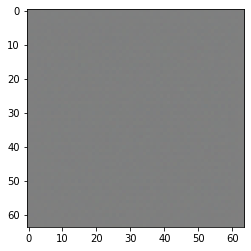

In [121]:
generator = make_generator_model((100,))

noise = np.random.normal(0, 1, 100)
label = train_attrs[0]
print(label.shape)

generated_image = generator.predict( [np.array([noise]), np.array([label])] )[0]
plt.imshow(unnormalize_img(generated_image), )

In [226]:
def make_valid_discriminator_model():
    input_layer = Input((64, 64, 3))
#     x = GaussianNoise(1)(input_layer)
    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', name='valid')(input_layer)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    
    x = Flatten()(x)
    x = Dense(64)(x) 
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    valid = Dense(1, activation='sigmoid')(x)
    
    return Model(input_layer, valid)

In [123]:
discriminator_valid = make_valid_discriminator_model()
discriminator_valid.summary()
valid = discriminator_valid.predict(np.array([generated_image]))


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
valid (Conv2D)               (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0   

In [276]:
def make_attr_discriminator_model():
    input_layer = Input((64, 64, 3))
    
#     x = GaussianNoise(1)(input_layer)
    
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='same', name='attr')(input_layer)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)

    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)


#     x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
#     x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    
#     x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
#     x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    
    x = Dense(32)(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    
    attr = Dense(10, activation='sigmoid')(x)
    
    return Model(input_layer, attr)

In [277]:
discriminator_attr = make_attr_discriminator_model()
discriminator_attr.summary()
attrs = discriminator_attr.predict(np.array([generated_image]))

Model: "model_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_111 (InputLayer)       [(None, 64, 64, 3)]       0         
_________________________________________________________________
attr (Conv2D)                (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_546 (LeakyReLU)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_270 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
leaky_re_lu_547 (LeakyReLU)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_271 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
leaky_re_lu_548 (LeakyReLU)  (None, 16, 16, 64)        0  

In [153]:
cross_entropy = BinaryCrossentropy(from_logits=False)

@tf.function
def discriminator_valid_loss(real_output, fake_output, flip):
    
    if flip:
        fake_labels = tf.random.uniform(fake_output.shape, minval=0.9, maxval=1.0)
        real_labels = tf.random.uniform(real_output.shape, minval=0.0, maxval=0.1)
    else:
        real_labels = tf.random.uniform(real_output.shape, minval=0.9, maxval=1.0)
        fake_labels = tf.random.uniform(fake_output.shape, minval=0.0, maxval=0.1)

        
    real_loss = cross_entropy(real_labels, real_output)
    fake_loss = cross_entropy(fake_labels, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss, real_loss, fake_loss

In [154]:
# mse = MeanSquaredError()

@tf.function
def discriminator_attribute_loss_real(real_output, real_attributes):
    return cross_entropy(real_output, real_attributes)

@tf.function
def discriminator_attribute_loss_fake(fake_output, fake_attributes):
    return cross_entropy(fake_output, fake_attributes)

In [282]:
@tf.function
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

@tf.function
def generator_attr_loss(fake_attr_output, sampled_attrs):
#     tf.print(fake_attr_output[0], summarize=10)
#     tf.print(sampled_attrs[0], summarize=10, end='\n\n')
    return cross_entropy(fake_attr_output, sampled_attrs)

In [285]:
@tf.function
def train_step(images, attrs, sampled_attrs, flip, warmup):
    noise = tf.random.truncated_normal([32, 100], dtype=tf.dtypes.float64)
    
#     sampled_attrs = tf.cast(tf.random.uniform([32, 312], minval=0, maxval=2, dtype='int32'), 'float32') # Need to make this smarter. Only one 1 per attr.
    
#     attrs = tf.reshape(attrs, (attrs.shape[0], 1))
    
    gen_losses = []
    gen_valid_losses = []
    gen_attr_losses = []
    disc_losses = []
    disc_real_losses = []
    disc_fake_losses = []
    disc_attr_real_losses = []
    disc_attr_fake_losses = []

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape_valid, tf.GradientTape() as disc_tape_attr:
        generated_images = generator([noise, sampled_attrs], training=True)
        
        real_output = discriminator_valid(images, training=True)
        fake_output = discriminator_valid(generated_images, training=True)
        
        real_attr_output = discriminator_attr(images, training=True)
        fake_attr_output = discriminator_attr(generated_images, training=True)
        
        gen_valid_loss = generator_loss(fake_output)
        gen_attr_loss = generator_attr_loss(fake_attr_output, sampled_attrs)
        gen_loss = ((2.0 - warmup) * gen_valid_loss + warmup * gen_attr_loss)
        
        disc_valid_loss, disc_real_loss, disc_fake_loss = discriminator_valid_loss(real_output, fake_output, flip)
        disc_attr_real_loss = discriminator_attribute_loss_real(real_attr_output, attrs)
        disc_attr_fake_loss = discriminator_attribute_loss_fake(fake_attr_output, sampled_attrs)
        disc_attr_loss = ((2.0 - warmup) * disc_attr_real_loss + warmup * disc_attr_fake_loss)
#         disc_loss += ((2.0 - warmup) * disc_attr_real_loss + warmup * disc_attr_fake_loss)
        
        
        gen_losses.append(K.mean(gen_loss))
        gen_valid_losses.append(K.mean(gen_valid_loss))
        gen_attr_losses.append(K.mean(gen_attr_loss))
        disc_losses.append(K.mean(disc_valid_loss))
        disc_real_losses.append(K.mean(disc_real_loss))
        disc_fake_losses.append(K.mean(disc_fake_loss))
        disc_attr_real_losses.append(K.mean(disc_attr_real_loss))
        disc_attr_fake_losses.append(K.mean(disc_attr_fake_loss))
    
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    gradients_of_discriminator_valid = disc_tape_valid.gradient(disc_valid_loss, discriminator_valid.trainable_variables)
    
    gradients_of_discriminator_attr = disc_tape_attr.gradient(disc_attr_loss, discriminator_attr.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    discriminator_valid_optimizer.apply_gradients(zip(gradients_of_discriminator_valid, discriminator_valid.trainable_variables))
    
    discriminator_attr_optimizer.apply_gradients(zip(gradients_of_discriminator_attr, discriminator_attr.trainable_variables))

    return (gen_losses, gen_valid_losses, gen_attr_losses, disc_losses, disc_real_losses, disc_fake_losses, disc_attr_real_losses, disc_attr_fake_losses)

In [257]:
def train(train_imgs, train_attrs, epochs, warmup):
    gen_loss_all = []
    gen_valid_loss_all = []
    gen_attr_loss_all = []
    disc_loss_all = []
    disc_loss_real_all = []
    disc_loss_fake_all = []
    disc_attr_loss_real_all = []
    disc_attr_loss_fake_all = []
    warmup_step = 1./1000.
    
    num_samples = len(train_imgs)
    batch_counter = 0
    
    for epoch in range(epochs):
        start = time.time()
        
        gen_loss_epoch = [1, 0]
        gen_valid_loss_epoch = [1, 0]
        gen_attr_loss_epoch = [1, 0]
        disc_loss_epoch = [1, 0]
        disc_loss_real_epoch = [1, 0]
        disc_loss_fake_epoch = [1, 0]
        disc_attr_loss_real_epoch = [1, 0]
        disc_attr_loss_fake_epoch = [1, 0]
        
        seed = np.random.randint(0, 10000)
        np.random.seed(seed)
        np.random.shuffle(train_imgs)
        np.random.seed(seed)
        np.random.shuffle(train_attrs)
        
        for idx, i in enumerate(range(0, num_samples - 32, 32)):
            
            gen_loss_batch, gen_valid_loss_batch, gen_attr_loss_batch, disc_loss_batch, disc_loss_real_batch, disc_loss_fake_batch, disc_attr_loss_real_batch, disc_attr_loss_fake_batch = train_step(train_imgs[i:(i+32)], train_attrs[i:(i+32)], train_attrs[np.random.choice(range(len(train_attrs)), 32, replace=False)], batch_counter % 20 == 0, tf.constant(warmup, dtype='float32'))

            gen_loss_epoch[0] += 1
            gen_valid_loss_epoch[0] += 1
            gen_attr_loss_epoch[0] += 1
            disc_loss_epoch[0] += 1
            disc_loss_real_epoch[0] += 1
            disc_loss_fake_epoch[0] += 1
            disc_attr_loss_real_epoch[0] += 1
            disc_attr_loss_fake_epoch[0] += 1
            gen_loss_epoch[1] += np.mean(gen_loss_batch)
            gen_valid_loss_epoch[1] += np.mean(gen_valid_loss_batch)
            gen_attr_loss_epoch[1] += np.mean(gen_attr_loss_batch)
            disc_loss_epoch[1] += np.mean(disc_loss_batch)
            disc_loss_real_epoch[1] += np.mean(disc_loss_real_batch)
            disc_loss_fake_epoch[1] += np.mean(disc_loss_fake_batch)
            disc_attr_loss_real_epoch[1] += np.mean(disc_attr_loss_real_batch)
            disc_attr_loss_fake_epoch[1] += np.mean(disc_attr_loss_fake_batch)
            
            batch_counter += 1
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print(f'Gen loss: {gen_loss_epoch[1]/gen_loss_epoch[0]}, Gen valid loss: {gen_valid_loss_epoch[1]/gen_valid_loss_epoch[0]}, Gen attr loss: {gen_attr_loss_epoch[1]/gen_attr_loss_epoch[0]}, Disc valid loss: {disc_loss_epoch[1]/disc_loss_epoch[0]}, Disc valid real loss: {disc_loss_real_epoch[1]/disc_loss_real_epoch[0]}, Disc valid fake loss: {disc_loss_fake_epoch[1]/disc_loss_fake_epoch[0]}, Disc attr loss: {(disc_attr_loss_real_epoch[1] + disc_attr_loss_fake_epoch[1])/(disc_attr_loss_real_epoch[0])}, Disc attr real loss: {disc_attr_loss_real_epoch[1]/disc_attr_loss_real_epoch[0]}, Disc attr fake loss: {disc_attr_loss_fake_epoch[1]/disc_attr_loss_fake_epoch[0]}')
        
        gen_loss_all.append(gen_loss_epoch[1]/gen_loss_epoch[0])
        gen_valid_loss_all.append(gen_valid_loss_epoch[1]/gen_valid_loss_epoch[0])
        gen_attr_loss_all.append(gen_attr_loss_epoch[1]/gen_attr_loss_epoch[0])
        disc_loss_all.append(disc_loss_epoch[1]/disc_loss_epoch[0])
        disc_loss_real_all.append(disc_loss_real_epoch[1]/disc_loss_real_epoch[0])
        disc_loss_fake_all.append(disc_loss_fake_epoch[1]/disc_loss_fake_epoch[0])
        disc_attr_loss_real_all.append(disc_attr_loss_real_epoch[1]/disc_attr_loss_real_epoch[0])
        disc_attr_loss_fake_all.append(disc_attr_loss_fake_epoch[1]/disc_attr_loss_fake_epoch[0])
        
        if warmup < 1:
            warmup += warmup_step
    
    return (gen_loss_all, gen_valid_loss_all, gen_attr_loss_all, disc_loss_all, disc_loss_real_all, disc_loss_fake_all, disc_attr_loss_real_all, disc_attr_loss_fake_all, warmup)
    


In [258]:
def long_train(starting_checkpoint=0, num_checkpoints=0, checkpoint_interval=0, g_hist=None, g_valid_hist=None, g_attr_hist=None, d_hist=None, d_real_hist=None, d_fake_hist=None, d_attr_real_hist=None, d_attr_fake_hist=None, noise=None, attr=None, save_files=False, warmup=0.):

    for i in range(starting_checkpoint, starting_checkpoint + num_checkpoints):
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        print('')
        print(f'Starting checkpoint {i}')
        print('')
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        
        gen_temp, gen_valid_temp, gen_attr_temp, disc_temp, disc_real_temp, disc_fake_temp, disc_attr_real_temp, disc_attr_fake_temp, warmup = train(train_imgs, train_attrs, checkpoint_interval, warmup)
        
        g_hist += gen_temp
        g_valid_hist += gen_valid_temp
        g_attr_hist += gen_attr_temp
        d_hist += disc_temp
        d_real_hist += disc_real_temp
        d_fake_hist += disc_fake_temp
        d_attr_real_hist += disc_attr_real_temp
        d_attr_fake_hist += disc_attr_fake_temp
        generated_image = generator.predict( [np.array([noise]), np.array([attr])])[0]
        plt.imshow(unnormalize_img(generated_image))
        if save_files:
            plt.savefig('./results/prog-imgs/bird-gan-attributes-split-sigmoid-simple/' + str((i+1)*checkpoint_interval) + '.png')
        plt.show()
        if save_files:
            generator.save_weights('./results/weights/bird-gan-attributes-split-sigmoid-simple/gen_weights_attributes_split_' + str((i+1)*checkpoint_interval) + '.h5')
            discriminator_valid.save_weights('./results/weights/bird-gan-attributes-split-sigmoid-simple/disc_weights_attributes_split_valid_' + str((i+1)*checkpoint_interval) + '.h5')
            discriminator_attr.save_weights('./results/weights/bird-gan-attributes-split-sigmoid-simple/disc_weights_attributes_split_attr_' + str((i+1)*checkpoint_interval) + '.h5')
    
    return starting_checkpoint + num_checkpoints, totalepochs, warmup

In [283]:
discriminator_valid = make_valid_discriminator_model()
discriminator_attr = make_attr_discriminator_model()
generator = make_generator_model((100,))
generator_optimizer = Adam(1e-4, beta_1=0.5)
discriminator_valid_optimizer = Adam(1e-4, beta_1=0.5)
discriminator_attr_optimizer = Adam(1e-4, beta_1=0.5)

In [284]:
# To get passed into training function and get modified
# Run cell when starting from scratch
gen_loss_hist = []
gen_valid_loss_hist = []
gen_attr_loss_hist = []
disc_loss_hist = []
disc_loss_real_hist = []
disc_loss_fake_hist = []
disc_attr_loss_real_hist = []
disc_attr_loss_fake_hist = []
noise100 = np.random.normal(0, 1, 100)
attr = train_attrs[0]
next_starting_checkpoint = 0
totalepochs = 0
warmup = 1.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 10

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 32.66533017158508 sec
Gen loss: 1.625405177191344, Gen valid loss: 1.5342812815978921, Gen attr loss: 0.091123890992485, Disc valid loss: 0.9752232125458032, Disc valid real loss: 0.5057378224725646, Disc valid fake loss: 0.4694853899924736, Disc attr loss: 2.138113425274911, Disc attr real loss: 2.046989534282426, Disc attr fake loss: 0.091123890992485
Time for epoch 2 is 33.469358921051025 sec
Gen loss: 1.61647534079668, Gen valid loss: 1.5368699148741518, Gen attr loss: 0.07960542794428849, Disc valid loss: 0.9645144320761931, Disc valid real loss: 0.5074993731368201, Disc valid fake loss: 0.4570150582932521, Disc attr loss: 2.126454677445504, Disc attr real loss: 2.0468492495012156, Disc attr fake loss: 0.07960542794428849
Time for epoch 3 is 33.74968433380127 sec
Gen loss: 1.620461793449836, Gen valid loss: 1.5315328431000232, Gen attr loss: 0.08

Time for epoch 23 is 34.099382162094116 sec
Gen loss: 1.613637304887539, Gen valid loss: 1.5222111177961355, Gen attr loss: 0.09142618792426016, Disc valid loss: 0.9806905747429142, Disc valid real loss: 0.5118904050772752, Disc valid fake loss: 0.4688001712001759, Disc attr loss: 2.1265712135135386, Disc attr real loss: 2.0351450255892787, Disc attr fake loss: 0.09142618792426016
Time for epoch 24 is 33.992207050323486 sec
Gen loss: 1.589665127640494, Gen valid loss: 1.508416452381992, Gen attr loss: 0.08124867483509661, Disc valid loss: 0.9731499667413189, Disc valid real loss: 0.5063822060258085, Disc valid fake loss: 0.46676776233081246, Disc attr loss: 2.1101798125041507, Disc attr real loss: 2.028931137669054, Disc attr fake loss: 0.08124867483509661
Time for epoch 25 is 34.03886795043945 sec
Gen loss: 1.6144923882755806, Gen valid loss: 1.525521741649969, Gen attr loss: 0.0889706448617744, Disc valid loss: 0.9769601996352033, Disc valid real loss: 0.5097463287635224, Disc valid 

Time for epoch 45 is 34.250168323516846 sec
Gen loss: 1.6043798028615108, Gen valid loss: 1.5177378890314077, Gen attr loss: 0.08664190869819331, Disc valid loss: 0.9803831850287068, Disc valid real loss: 0.5130090410631847, Disc valid fake loss: 0.4673741423502201, Disc attr loss: 2.1120854803910762, Disc attr real loss: 2.025443571692883, Disc attr fake loss: 0.08664190869819331
Time for epoch 46 is 34.37463879585266 sec
Gen loss: 1.6164695392779218, Gen valid loss: 1.5256994138888227, Gen attr loss: 0.09077012667992285, Disc valid loss: 0.975883239329992, Disc valid real loss: 0.5108879437937646, Disc valid fake loss: 0.46499529731305955, Disc attr loss: 2.1122188623021323, Disc attr real loss: 2.0214487356222097, Disc attr fake loss: 0.09077012667992285
Time for epoch 47 is 34.168763637542725 sec
Gen loss: 1.6051953187802943, Gen valid loss: 1.5175589239048117, Gen attr loss: 0.08763639456683041, Disc valid loss: 0.9743267460890256, Disc valid real loss: 0.5091866663477931, Disc va

Time for epoch 67 is 34.44820165634155 sec
Gen loss: 1.6046704108799053, Gen valid loss: 1.517763473477144, Gen attr loss: 0.08690693413014151, Disc valid loss: 0.9733275840599039, Disc valid real loss: 0.5047141733531383, Disc valid fake loss: 0.468613410222175, Disc attr loss: 2.0939620290248198, Disc attr real loss: 2.007055094894678, Disc attr fake loss: 0.08690693413014151
Time for epoch 68 is 34.517775774002075 sec
Gen loss: 1.6066530059346662, Gen valid loss: 1.5223674787092338, Gen attr loss: 0.08428552856527342, Disc valid loss: 0.9821590530840039, Disc valid real loss: 0.5125686168509124, Disc valid fake loss: 0.4695904372022727, Disc attr loss: 2.091471858026968, Disc attr real loss: 2.0071863294616947, Disc attr fake loss: 0.08428552856527342
Time for epoch 69 is 34.57275438308716 sec
Gen loss: 1.6035429026053203, Gen valid loss: 1.5119141272413053, Gen attr loss: 0.09162877450348351, Disc valid loss: 0.9729440267170025, Disc valid real loss: 0.5084866913676584, Disc valid 

Time for epoch 89 is 34.55442190170288 sec
Gen loss: 1.617546332883964, Gen valid loss: 1.5324069826906612, Gen attr loss: 0.08513935141127409, Disc valid loss: 0.9690195229964528, Disc valid real loss: 0.5073540883497171, Disc valid fake loss: 0.46166543553515177, Disc attr loss: 2.0792606842130517, Disc attr real loss: 1.9941213328017775, Disc attr fake loss: 0.08513935141127409
Time for epoch 90 is 34.349730491638184 sec
Gen loss: 1.6037546179805022, Gen valid loss: 1.516216617612658, Gen attr loss: 0.087537999235063, Disc valid loss: 0.9771808716985915, Disc valid real loss: 0.5101047923086781, Disc valid fake loss: 0.4670760829435778, Disc attr loss: 2.0805662070811906, Disc attr real loss: 1.9930282078461272, Disc attr fake loss: 0.087537999235063
Time for epoch 91 is 34.35983848571777 sec
Gen loss: 1.6170648627164887, Gen valid loss: 1.5299056858874271, Gen attr loss: 0.08715917995090826, Disc valid loss: 0.9753833379202742, Disc valid real loss: 0.5103190758525518, Disc valid f

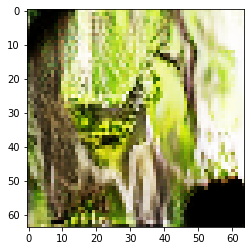

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 11

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 34.42715883255005 sec
Gen loss: 1.607890925110194, Gen valid loss: 1.5215657690999307, Gen attr loss: 0.08632515482955863, Disc valid loss: 0.9797803073071529, Disc valid real loss: 0.510485297861461, Disc valid fake loss: 0.4692950079111549, Disc attr loss: 2.072097636931392, Disc attr real loss: 1.9857724821018332, Disc attr fake loss: 0.08632515482955863
Time for epoch 2 is 34.4272027015686 sec
Gen loss: 1.615939140965945, Gen valid loss: 1.5304667038646171, Gen attr loss: 0.08547243622032555, Disc valid loss: 0.9728702001455354, Disc valid real loss: 0.5070486557354449, Disc valid fake loss: 0.46582154287555355, Disc attr loss: 2.074044072619282, Disc attr real loss: 1.9885716363989563, Disc attr fake loss: 0.08547243622032555
Time for epoch 3 is 34.4021897315979 sec
Gen loss: 1.6076274612731727, Gen valid loss: 1.5242671233205614, Gen attr loss: 

Time for epoch 23 is 34.35352277755737 sec
Gen loss: 1.5986863940065792, Gen valid loss: 1.5150807291511599, Gen attr loss: 0.08360566450715558, Disc valid loss: 0.985413760673709, Disc valid real loss: 0.5171821852363545, Disc valid fake loss: 0.4682315730951666, Disc attr loss: 2.057903920060569, Disc attr real loss: 1.9742982555534134, Disc attr fake loss: 0.08360566450715558
Time for epoch 24 is 34.33655524253845 sec
Gen loss: 1.5789409278208002, Gen valid loss: 1.4983340013964066, Gen attr loss: 0.08060692414471556, Disc valid loss: 0.9817360069370529, Disc valid real loss: 0.5128370975737326, Disc valid fake loss: 0.4688989099286759, Disc attr loss: 2.0479372584540325, Disc attr real loss: 1.967330334309317, Disc attr fake loss: 0.08060692414471556
Time for epoch 25 is 34.35578203201294 sec
Gen loss: 1.6014762099196271, Gen valid loss: 1.5176141517272164, Gen attr loss: 0.0838620577958726, Disc valid loss: 0.9703236143117352, Disc valid real loss: 0.5066737990553786, Disc valid f

Time for epoch 45 is 34.48059391975403 sec
Gen loss: 1.5924920415490624, Gen valid loss: 1.515890733820959, Gen attr loss: 0.0766013059017031, Disc valid loss: 0.9744322986460636, Disc valid real loss: 0.5090675454960283, Disc valid fake loss: 0.46536475266544475, Disc attr loss: 2.0355660553051425, Disc attr real loss: 1.9589647494034392, Disc attr fake loss: 0.0766013059017031
Time for epoch 46 is 34.54216980934143 sec
Gen loss: 1.5905722453988342, Gen valid loss: 1.5135082907792998, Gen attr loss: 0.07706395493627975, Disc valid loss: 0.9796382741230291, Disc valid real loss: 0.5120935734856097, Disc valid fake loss: 0.46754470192966097, Disc attr loss: 2.034371293327819, Disc attr real loss: 1.9573073383915391, Disc attr fake loss: 0.07706395493627975
Time for epoch 47 is 34.47355365753174 sec
Gen loss: 1.5900488429599338, Gen valid loss: 1.5089447197875356, Gen attr loss: 0.08110412407248997, Disc valid loss: 0.976769205677477, Disc valid real loss: 0.5102462358267973, Disc valid 

Time for epoch 67 is 34.35582685470581 sec
Gen loss: 1.575352593812193, Gen valid loss: 1.492779772133039, Gen attr loss: 0.0825728179804785, Disc valid loss: 0.9833182477692601, Disc valid real loss: 0.5127547314658074, Disc valid fake loss: 0.4705635163034527, Disc attr loss: 2.0309477803995075, Disc attr real loss: 1.9483749624190292, Disc attr fake loss: 0.0825728179804785
Time for epoch 68 is 34.587214946746826 sec
Gen loss: 1.5756194245847583, Gen valid loss: 1.496254556870396, Gen attr loss: 0.07936486851109678, Disc valid loss: 0.9925104113129096, Disc valid real loss: 0.5178724716349346, Disc valid fake loss: 0.4746379419393979, Disc attr loss: 2.0220655078378176, Disc attr real loss: 1.942700639326721, Disc attr fake loss: 0.07936486851109678
Time for epoch 69 is 34.51517152786255 sec
Gen loss: 1.5983998077671702, Gen valid loss: 1.5088094905786076, Gen attr loss: 0.08959031693368281, Disc valid loss: 0.9788301183279291, Disc valid real loss: 0.5130536666084434, Disc valid fa

Time for epoch 89 is 34.58612394332886 sec
Gen loss: 1.5874232853331216, Gen valid loss: 1.5067195524045123, Gen attr loss: 0.08070373451284651, Disc valid loss: 0.9831338271216002, Disc valid real loss: 0.5134800413275152, Disc valid fake loss: 0.4696537848249037, Disc attr loss: 2.012602654706444, Disc attr real loss: 1.9318989201935972, Disc attr fake loss: 0.08070373451284651
Time for epoch 90 is 34.57099175453186 sec
Gen loss: 1.5752698279977815, Gen valid loss: 1.4976864907799698, Gen attr loss: 0.07758333748089358, Disc valid loss: 0.9805606261178407, Disc valid real loss: 0.5098474603196793, Disc valid fake loss: 0.4707131657981614, Disc attr loss: 2.0056713395694867, Disc attr real loss: 1.9280880020885933, Disc attr fake loss: 0.07758333748089358
Time for epoch 91 is 34.61028337478638 sec
Gen loss: 1.5745942534469977, Gen valid loss: 1.5038446443190743, Gen attr loss: 0.07074960888184142, Disc valid loss: 0.9840247685993267, Disc valid real loss: 0.5119528729256576, Disc vali

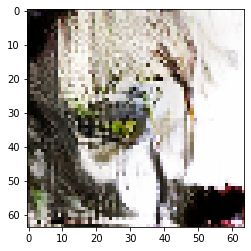

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 12

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 34.532206535339355 sec
Gen loss: 1.5823580957040555, Gen valid loss: 1.500837528770209, Gen attr loss: 0.0815205669971606, Disc valid loss: 0.9940005951134493, Disc valid real loss: 0.5192507886628148, Disc valid fake loss: 0.47474980685446, Disc attr loss: 2.004672325625324, Disc attr real loss: 1.923151758628163, Disc attr fake loss: 0.0815205669971606
Time for epoch 2 is 34.797934770584106 sec
Gen loss: 1.5684272842355538, Gen valid loss: 1.4952566781987342, Gen attr loss: 0.07317060600762615, Disc valid loss: 0.9838033806340805, Disc valid real loss: 0.5129814298979958, Disc valid fake loss: 0.47082195396668863, Disc attr loss: 1.9988335222117737, Disc attr real loss: 1.9256629162041476, Disc attr fake loss: 0.07317060600762615
Time for epoch 3 is 34.67092847824097 sec
Gen loss: 1.5603338150474113, Gen valid loss: 1.4904111303934238, Gen attr loss

Time for epoch 23 is 34.937604665756226 sec
Gen loss: 1.5454713807196474, Gen valid loss: 1.4753251511876175, Gen attr loss: 0.07014623164556118, Disc valid loss: 0.9922899410007445, Disc valid real loss: 0.5176643531335402, Disc valid fake loss: 0.47462559085551315, Disc attr loss: 1.9793590816192244, Disc attr real loss: 1.9092128499736631, Disc attr fake loss: 0.07014623164556118
Time for epoch 24 is 34.899261713027954 sec
Gen loss: 1.5666606629767068, Gen valid loss: 1.4857345829165078, Gen attr loss: 0.08092607956088826, Disc valid loss: 0.9835780206411512, Disc valid real loss: 0.5137881309520907, Disc valid fake loss: 0.4697898903351812, Disc attr loss: 1.9934778783555391, Disc attr real loss: 1.9125517987946508, Disc attr fake loss: 0.08092607956088826
Time for epoch 25 is 34.91353440284729 sec
Gen loss: 1.5799028195016753, Gen valid loss: 1.501589910447759, Gen attr loss: 0.07831290726795358, Disc valid loss: 0.9872807689152436, Disc valid real loss: 0.5124746602240616, Disc v

Time for epoch 45 is 34.90119433403015 sec
Gen loss: 1.5817498918471298, Gen valid loss: 1.4986976824478728, Gen attr loss: 0.08305220826638925, Disc valid loss: 0.981507244471935, Disc valid real loss: 0.5138443531544228, Disc valid fake loss: 0.4676628925289888, Disc attr loss: 1.9818415352624041, Disc attr real loss: 1.898789326996015, Disc attr fake loss: 0.08305220826638925
Time for epoch 46 is 34.90175771713257 sec
Gen loss: 1.557946367638544, Gen valid loss: 1.4910032154744879, Gen attr loss: 0.06694314866189306, Disc valid loss: 0.9890840247394593, Disc valid real loss: 0.517158677907494, Disc valid fake loss: 0.4719253451358981, Disc attr loss: 1.9610099834993335, Disc attr real loss: 1.8940668348374405, Disc attr fake loss: 0.06694314866189306
Time for epoch 47 is 35.01921582221985 sec
Gen loss: 1.5758584741008315, Gen valid loss: 1.4920506034763201, Gen attr loss: 0.08380787092729872, Disc valid loss: 0.9866256377884366, Disc valid real loss: 0.5140443643741814, Disc valid f

Time for epoch 67 is 34.907347440719604 sec
Gen loss: 1.556176890848775, Gen valid loss: 1.4898516731210518, Gen attr loss: 0.06632521531197744, Disc valid loss: 0.9862380727196773, Disc valid real loss: 0.516896158133742, Disc valid fake loss: 0.46934191393981456, Disc attr loss: 1.9509974264266075, Disc attr real loss: 1.8846722111146301, Disc attr fake loss: 0.06632521531197744
Time for epoch 68 is 35.15055274963379 sec
Gen loss: 1.5731514947524239, Gen valid loss: 1.5014493604339558, Gen attr loss: 0.07170213686995136, Disc valid loss: 0.9865152937609974, Disc valid real loss: 0.5152469357339348, Disc valid fake loss: 0.47126835625023056, Disc attr loss: 1.9578723416088888, Disc attr real loss: 1.8861702047389375, Disc attr fake loss: 0.07170213686995136
Time for epoch 69 is 35.03629732131958 sec
Gen loss: 1.5645543136570834, Gen valid loss: 1.4911611564760285, Gen attr loss: 0.0733931555701988, Disc valid loss: 0.9865371121300591, Disc valid real loss: 0.5145635748620279, Disc val

Time for epoch 89 is 34.92647457122803 sec
Gen loss: 1.565159426956642, Gen valid loss: 1.4876258948308019, Gen attr loss: 0.07753353362526878, Disc valid loss: 0.9855458948024243, Disc valid real loss: 0.5132325084874947, Disc valid fake loss: 0.47231338615339946, Disc attr loss: 1.9469694962479964, Disc attr real loss: 1.8694359626227277, Disc attr fake loss: 0.07753353362526878
Time for epoch 90 is 34.89129662513733 sec
Gen loss: 1.5711289114422269, Gen valid loss: 1.5007738314346892, Gen attr loss: 0.07035507950918692, Disc valid loss: 0.9816361815948796, Disc valid real loss: 0.5129897982932041, Disc valid fake loss: 0.4686463818882862, Disc attr loss: 1.9370639078524723, Disc attr real loss: 1.8667088283432856, Disc attr fake loss: 0.07035507950918692
Time for epoch 91 is 34.969032287597656 sec
Gen loss: 1.5476138220246891, Gen valid loss: 1.4742669009257785, Gen attr loss: 0.07334692227418942, Disc valid loss: 0.9970880522314449, Disc valid real loss: 0.5205221857804916, Disc va

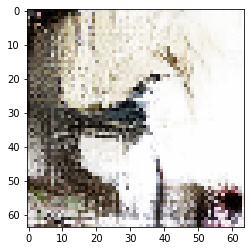

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 13

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 34.91522693634033 sec
Gen loss: 1.5530694703745649, Gen valid loss: 1.4836808478606103, Gen attr loss: 0.06938862323459695, Disc valid loss: 0.996176087274784, Disc valid real loss: 0.5210406714823188, Disc valid fake loss: 0.47513541821541827, Disc attr loss: 1.9283386196646501, Disc attr real loss: 1.8589499964300533, Disc attr fake loss: 0.06938862323459695
Time for epoch 2 is 34.90007185935974 sec
Gen loss: 1.567738903893365, Gen valid loss: 1.4965144376444623, Gen attr loss: 0.0712244637975341, Disc valid loss: 0.9839340089782467, Disc valid real loss: 0.5127211678318861, Disc valid fake loss: 0.4712128428424277, Disc attr loss: 1.9270085360984632, Disc attr real loss: 1.8557840723009291, Disc attr fake loss: 0.0712244637975341
Time for epoch 3 is 34.880473375320435 sec
Gen loss: 1.543367581315803, Gen valid loss: 1.476534431058217, Gen attr loss

Time for epoch 23 is 34.91170835494995 sec
Gen loss: 1.5559558257824038, Gen valid loss: 1.4770915889481542, Gen attr loss: 0.07886423942169007, Disc valid loss: 0.9972402598799729, Disc valid real loss: 0.5225955826157154, Disc valid fake loss: 0.4746446766181367, Disc attr loss: 1.9205682229249956, Disc attr real loss: 1.8417039835033056, Disc attr fake loss: 0.07886423942169007
Time for epoch 24 is 34.93610453605652 sec
Gen loss: 1.5553790770248992, Gen valid loss: 1.4823562433403037, Gen attr loss: 0.07302283152565957, Disc valid loss: 0.9852486163943117, Disc valid real loss: 0.5110876427756416, Disc valid fake loss: 0.47416097458785145, Disc attr loss: 1.9178875550077656, Disc attr real loss: 1.844864723482106, Disc attr fake loss: 0.07302283152565957
Time for epoch 25 is 34.94117784500122 sec
Gen loss: 1.5736867428472048, Gen valid loss: 1.4979171756160292, Gen attr loss: 0.07576956829747276, Disc valid loss: 0.9807260441909315, Disc valid real loss: 0.5086513730245554, Disc val

Time for epoch 45 is 34.98698711395264 sec
Gen loss: 1.5571773572342829, Gen valid loss: 1.4789117009336064, Gen attr loss: 0.07826565361573277, Disc valid loss: 0.9952788522573022, Disc valid real loss: 0.5184422258923693, Disc valid fake loss: 0.47683662596110726, Disc attr loss: 1.9146910058415145, Disc attr real loss: 1.8364253522257818, Disc attr fake loss: 0.07826565361573277
Time for epoch 46 is 34.98317265510559 sec
Gen loss: 1.5550897040664342, Gen valid loss: 1.4782082223633763, Gen attr loss: 0.0768814799486885, Disc valid loss: 0.9899748051715737, Disc valid real loss: 0.5123840871703657, Disc valid fake loss: 0.4775907185665637, Disc attr loss: 1.911945173110268, Disc attr real loss: 1.8350636931615794, Disc attr fake loss: 0.0768814799486885
Time for epoch 47 is 34.96261429786682 sec
Gen loss: 1.5699220895767212, Gen valid loss: 1.4938435968021713, Gen attr loss: 0.07607849118771065, Disc valid loss: 0.9850883524269269, Disc valid real loss: 0.5139803618273437, Disc valid

Time for epoch 67 is 35.03382682800293 sec
Gen loss: 1.5524703209316182, Gen valid loss: 1.4815426573843813, Gen attr loss: 0.07092766223114223, Disc valid loss: 0.9894036883261146, Disc valid real loss: 0.5177679377681195, Disc valid fake loss: 0.4716357502349347, Disc attr loss: 1.89451063904535, Disc attr real loss: 1.823582976814208, Disc attr fake loss: 0.07092766223114223
Time for epoch 68 is 34.87267756462097 sec
Gen loss: 1.5503908066245597, Gen valid loss: 1.4825413847357276, Gen attr loss: 0.0678494211685624, Disc valid loss: 0.99794703625082, Disc valid real loss: 0.5186379172291536, Disc valid fake loss: 0.479309116275653, Disc attr loss: 1.8921110794054716, Disc attr real loss: 1.8242616582369093, Disc attr fake loss: 0.0678494211685624
Time for epoch 69 is 34.89755606651306 sec
Gen loss: 1.5486760242844662, Gen valid loss: 1.4797844305271055, Gen attr loss: 0.0688915943714113, Disc valid loss: 0.9899939335781708, Disc valid real loss: 0.5175117026499616, Disc valid fake l

Time for epoch 89 is 34.96795725822449 sec
Gen loss: 1.5438593209274416, Gen valid loss: 1.4795652249964273, Gen attr loss: 0.06429409569930568, Disc valid loss: 0.9850612192296078, Disc valid real loss: 0.5134607256266482, Disc valid fake loss: 0.47160049570285206, Disc attr loss: 1.8745180025277648, Disc attr real loss: 1.8102239068284591, Disc attr fake loss: 0.06429409569930568
Time for epoch 90 is 35.01121282577515 sec
Gen loss: 1.5531087974868816, Gen valid loss: 1.4822581160036206, Gen attr loss: 0.07085068119089837, Disc valid loss: 0.9891020116121142, Disc valid real loss: 0.5121401392508974, Disc valid fake loss: 0.4769618729265725, Disc attr loss: 1.8801786137451073, Disc attr real loss: 1.8093279325542089, Disc attr fake loss: 0.07085068119089837
Time for epoch 91 is 34.90587258338928 sec
Gen loss: 1.5455464919408162, Gen valid loss: 1.4695468533652907, Gen attr loss: 0.07599963707421589, Disc valid loss: 1.005774905526541, Disc valid real loss: 0.5254594227324333, Disc val

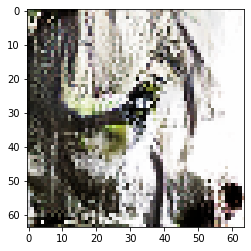

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 14

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 34.85544276237488 sec
Gen loss: 1.5547991713211142, Gen valid loss: 1.4884979033534766, Gen attr loss: 0.06630126604219341, Disc valid loss: 0.9945668681527218, Disc valid real loss: 0.5182179668085362, Disc valid fake loss: 0.476348904817085, Disc attr loss: 1.8729729563692354, Disc attr real loss: 1.8066716903270421, Disc attr fake loss: 0.06630126604219341
Time for epoch 2 is 35.03161430358887 sec
Gen loss: 1.5498386052888906, Gen valid loss: 1.4795824476696935, Gen attr loss: 0.07025615424021371, Disc valid loss: 0.9947346736422076, Disc valid real loss: 0.5180673073462354, Disc valid fake loss: 0.47666736556908623, Disc attr loss: 1.8759287243744567, Disc attr real loss: 1.805672570134243, Disc attr fake loss: 0.07025615424021371
Time for epoch 3 is 34.917060136795044 sec
Gen loss: 1.5597323767214932, Gen valid loss: 1.4859323424052417, Gen attr 

Time for epoch 23 is 34.841429710388184 sec
Gen loss: 1.5449803188887392, Gen valid loss: 1.4749629235849149, Gen attr loss: 0.07001739612279573, Disc valid loss: 1.0020753537736289, Disc valid real loss: 0.5203314782965797, Disc valid fake loss: 0.4817438763654652, Disc attr loss: 1.8606171417478756, Disc attr real loss: 1.7905997456250797, Disc attr fake loss: 0.07001739612279573
Time for epoch 24 is 34.8682324886322 sec
Gen loss: 1.5257621596499187, Gen valid loss: 1.4612695883283124, Gen attr loss: 0.06449256948436254, Disc valid loss: 0.9994189572851186, Disc valid real loss: 0.5178354762918581, Disc valid fake loss: 0.48158348139708607, Disc attr loss: 1.8546146849994745, Disc attr real loss: 1.790122115515112, Disc attr fake loss: 0.06449256948436254
Time for epoch 25 is 34.888774156570435 sec
Gen loss: 1.5216420278316591, Gen valid loss: 1.4458638526559846, Gen attr loss: 0.07577817484358335, Disc valid loss: 1.0097978685283402, Disc valid real loss: 0.5298409418361943, Disc va

Time for epoch 45 is 35.22661352157593 sec
Gen loss: 1.5184104090460593, Gen valid loss: 1.4544521163149577, Gen attr loss: 0.06395829280123026, Disc valid loss: 1.0011298548238388, Disc valid real loss: 0.5213672976668288, Disc valid fake loss: 0.47976255844925153, Disc attr loss: 1.8435221492814746, Disc attr real loss: 1.7795638564802443, Disc attr fake loss: 0.06395829280123026
Time for epoch 46 is 35.01336216926575 sec
Gen loss: 1.5449550898094488, Gen valid loss: 1.476410476495903, Gen attr loss: 0.0685446100006266, Disc valid loss: 0.9967668416700389, Disc valid real loss: 0.5160451670326192, Disc valid fake loss: 0.48072167811031913, Disc attr loss: 1.8505602458774242, Disc attr real loss: 1.7820156358767978, Disc attr fake loss: 0.0685446100006266
Time for epoch 47 is 34.83420777320862 sec
Gen loss: 1.5446026738743148, Gen valid loss: 1.4667191563583002, Gen attr loss: 0.07788351611887076, Disc valid loss: 0.9946614935146114, Disc valid real loss: 0.5202193539640122, Disc vali

Time for epoch 67 is 35.0361864566803 sec
Gen loss: 1.5351785621668912, Gen valid loss: 1.4711872148643017, Gen attr loss: 0.06399134569072781, Disc valid loss: 0.9932379336538031, Disc valid real loss: 0.5197526518568437, Disc valid fake loss: 0.4734852841391473, Disc attr loss: 1.835469269820555, Disc attr real loss: 1.7714779241298273, Disc attr fake loss: 0.06399134569072781
Time for epoch 68 is 35.01771306991577 sec
Gen loss: 1.5527969217558864, Gen valid loss: 1.477017580655209, Gen attr loss: 0.07577933947585086, Disc valid loss: 0.9986115795810048, Disc valid real loss: 0.519651204751436, Disc valid fake loss: 0.47896037386038764, Disc attr loss: 1.8468532429705848, Disc attr real loss: 1.771073903494734, Disc attr fake loss: 0.07577933947585086
Time for epoch 69 is 35.03735899925232 sec
Gen loss: 1.536657650296281, Gen valid loss: 1.4677769830879481, Gen attr loss: 0.06888067002527182, Disc valid loss: 0.9983416923339451, Disc valid real loss: 0.5192034976269172, Disc valid fa

Time for epoch 89 is 35.02371120452881 sec
Gen loss: 1.5397269670879292, Gen valid loss: 1.4723626559342795, Gen attr loss: 0.06736431112114168, Disc valid loss: 0.998244533370827, Disc valid real loss: 0.518827636713581, Disc valid fake loss: 0.4794168952034741, Disc attr loss: 1.8244340768349445, Disc attr real loss: 1.7570697657138028, Disc attr fake loss: 0.06736431112114168
Time for epoch 90 is 35.023773431777954 sec
Gen loss: 1.527227744823549, Gen valid loss: 1.4645017311178894, Gen attr loss: 0.06272601337535509, Disc valid loss: 0.9944475052479483, Disc valid real loss: 0.5175614322265636, Disc valid fake loss: 0.4768860746366868, Disc attr loss: 1.820582987647579, Disc attr real loss: 1.757856974272224, Disc attr fake loss: 0.06272601337535509
Time for epoch 91 is 34.95415377616882 sec
Gen loss: 1.5281235328534755, Gen valid loss: 1.4634522306240672, Gen attr loss: 0.06467130083355455, Disc valid loss: 1.0043839849430694, Disc valid real loss: 0.5253288337208715, Disc valid f

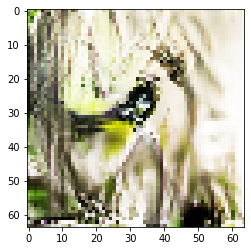

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 15

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 35.0760772228241 sec
Gen loss: 1.5336769786953603, Gen valid loss: 1.4709783773112104, Gen attr loss: 0.06269860111192421, Disc valid loss: 1.0067054634171773, Disc valid real loss: 0.5247319050759158, Disc valid fake loss: 0.4819735589873823, Disc attr loss: 1.8113637554152398, Disc attr real loss: 1.7486651543033156, Disc attr fake loss: 0.06269860111192421
Time for epoch 2 is 35.27627086639404 sec
Gen loss: 1.5215977717867388, Gen valid loss: 1.4546020134354671, Gen attr loss: 0.06699575740861026, Disc valid loss: 1.0002632137882677, Disc valid real loss: 0.5241561775123523, Disc valid fake loss: 0.47610703659897574, Disc attr loss: 1.8155259214061674, Disc attr real loss: 1.748530163997557, Disc attr fake loss: 0.06699575740861026
Time for epoch 3 is 34.9456148147583 sec
Gen loss: 1.5547972694645082, Gen valid loss: 1.4881652929595492, Gen attr lo

Time for epoch 23 is 35.1030797958374 sec
Gen loss: 1.5369643170013014, Gen valid loss: 1.4637344636245149, Gen attr loss: 0.07322985272158851, Disc valid loss: 1.0023851698330102, Disc valid real loss: 0.5191855319147187, Disc valid fake loss: 0.4831996379182914, Disc attr loss: 1.812592126157517, Disc attr real loss: 1.7393622734359286, Disc attr fake loss: 0.07322985272158851
Time for epoch 24 is 35.11932873725891 sec
Gen loss: 1.539121713741685, Gen valid loss: 1.4737437921487866, Gen attr loss: 0.0653779208046656, Disc valid loss: 0.9953459964858161, Disc valid real loss: 0.5156888909294677, Disc valid fake loss: 0.4796571074139458, Disc attr loss: 1.803570254243198, Disc attr real loss: 1.738192333438532, Disc attr fake loss: 0.0653779208046656
Time for epoch 25 is 35.09117579460144 sec
Gen loss: 1.534069941295841, Gen valid loss: 1.4649203634520533, Gen attr loss: 0.0691495792193999, Disc valid loss: 0.999889365864317, Disc valid real loss: 0.5187942602123995, Disc valid fake lo

Time for epoch 45 is 34.98945474624634 sec
Gen loss: 1.5301091015177368, Gen valid loss: 1.4684445089117943, Gen attr loss: 0.06166459079173729, Disc valid loss: 0.995791739564601, Disc valid real loss: 0.5177512833581062, Disc valid fake loss: 0.4780404574179714, Disc attr loss: 1.7915000892539388, Disc attr real loss: 1.7298354984622015, Disc attr fake loss: 0.06166459079173729
Time for epoch 46 is 35.17937421798706 sec
Gen loss: 1.5326167949169955, Gen valid loss: 1.469191261746373, Gen attr loss: 0.06342553209969375, Disc valid loss: 0.9994251172393964, Disc valid real loss: 0.5176510936845609, Disc valid fake loss: 0.4817740200819362, Disc attr loss: 1.7945628869452939, Disc attr real loss: 1.7311373548456002, Disc attr fake loss: 0.06342553209969375
Time for epoch 47 is 35.28733205795288 sec
Gen loss: 1.513022298089211, Gen valid loss: 1.4530195388690565, Gen attr loss: 0.060002759531224734, Disc valid loss: 1.003014506040227, Disc valid real loss: 0.5224659358098255, Disc valid 

Time for epoch 67 is 35.285996198654175 sec
Gen loss: 1.5289918151974355, Gen valid loss: 1.4663695384493365, Gen attr loss: 0.06262227459729196, Disc valid loss: 0.993749968081632, Disc valid real loss: 0.5139269327245107, Disc valid fake loss: 0.4798230354378863, Disc attr loss: 1.7819677235448261, Disc attr real loss: 1.7193454489475344, Disc attr fake loss: 0.06262227459729196
Time for epoch 68 is 34.98782968521118 sec
Gen loss: 1.5366723750664937, Gen valid loss: 1.4715787999352143, Gen attr loss: 0.06509357668947707, Disc valid loss: 1.0024657591894712, Disc valid real loss: 0.5178149821473977, Disc valid fake loss: 0.4846507751844763, Disc attr loss: 1.7871613060953944, Disc attr real loss: 1.7220677294059175, Disc attr fake loss: 0.06509357668947707
Time for epoch 69 is 35.389798641204834 sec
Gen loss: 1.5275641166097749, Gen valid loss: 1.4589078028996785, Gen attr loss: 0.06865631620849352, Disc valid loss: 1.0036454244357784, Disc valid real loss: 0.5241952455302241, Disc va

Time for epoch 89 is 35.3486225605011 sec
Gen loss: 1.5147579804991642, Gen valid loss: 1.455635629372222, Gen attr loss: 0.059122349699463506, Disc valid loss: 0.9990428240318608, Disc valid real loss: 0.5192580379767793, Disc valid fake loss: 0.47978478686273257, Disc attr loss: 1.7653880474953108, Disc attr real loss: 1.7062656977958472, Disc attr fake loss: 0.059122349699463506
Time for epoch 90 is 35.295040130615234 sec
Gen loss: 1.5257709372011303, Gen valid loss: 1.4539149650713292, Gen attr loss: 0.07185597109063943, Disc valid loss: 1.0062139578628022, Disc valid real loss: 0.5270942317114936, Disc valid fake loss: 0.47911972744355036, Disc attr loss: 1.7755782432295708, Disc attr real loss: 1.7037222721389316, Disc attr fake loss: 0.07185597109063943
Time for epoch 91 is 34.9788236618042 sec
Gen loss: 1.5337619500431587, Gen valid loss: 1.4665024096403665, Gen attr loss: 0.06725953975866741, Disc valid loss: 1.001843969511792, Disc valid real loss: 0.5229096484539631, Disc va

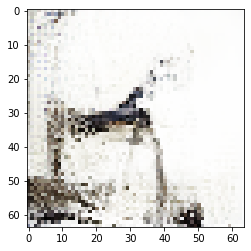

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 16

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 35.201775312423706 sec
Gen loss: 1.5227273211569643, Gen valid loss: 1.4660089553856268, Gen attr loss: 0.05671836701560275, Disc valid loss: 1.0031567963804333, Disc valid real loss: 0.5223806573931118, Disc valid fake loss: 0.480776138583496, Disc attr loss: 1.7566328196834076, Disc attr real loss: 1.699914452667805, Disc attr fake loss: 0.05671836701560275
Time for epoch 2 is 35.20426893234253 sec
Gen loss: 1.525198463501969, Gen valid loss: 1.459267780063598, Gen attr loss: 0.0659306816846954, Disc valid loss: 0.9975927607799934, Disc valid real loss: 0.5168301114221898, Disc valid fake loss: 0.48076264919627326, Disc attr loss: 1.7676455992578746, Disc attr real loss: 1.7017149175731794, Disc attr fake loss: 0.0659306816846954
Time for epoch 3 is 35.24382972717285 sec
Gen loss: 1.5322296444962664, Gen valid loss: 1.4701373977712822, Gen attr loss

Time for epoch 23 is 35.19348621368408 sec
Gen loss: 1.5214228494380548, Gen valid loss: 1.4587341233643736, Gen attr loss: 0.06268872467648366, Disc valid loss: 1.0136084626037576, Disc valid real loss: 0.5267946848539802, Disc valid fake loss: 0.4868137786381936, Disc attr loss: 1.752578254855784, Disc attr real loss: 1.6898895301793002, Disc attr fake loss: 0.06268872467648366
Time for epoch 24 is 35.179686069488525 sec
Gen loss: 1.5224590811949112, Gen valid loss: 1.4509329476007602, Gen attr loss: 0.0715261356526508, Disc valid loss: 0.9981932401010983, Disc valid real loss: 0.5152459083210809, Disc valid fake loss: 0.48294733169925247, Disc attr loss: 1.7630477842831909, Disc attr real loss: 1.6915216486305402, Disc attr fake loss: 0.0715261356526508
Time for epoch 25 is 35.16398477554321 sec
Gen loss: 1.5312323935309722, Gen valid loss: 1.4615898445692812, Gen attr loss: 0.06964254792093737, Disc valid loss: 0.9979313603907742, Disc valid real loss: 0.5164370479460977, Disc vali

Time for epoch 45 is 35.27179527282715 sec
Gen loss: 1.5349247714045249, Gen valid loss: 1.4724272709228805, Gen attr loss: 0.06249749937410018, Disc valid loss: 0.996084976971634, Disc valid real loss: 0.5140524823168106, Disc valid fake loss: 0.48203249538170934, Disc attr loss: 1.741359118869864, Disc attr real loss: 1.678861619495764, Disc attr fake loss: 0.06249749937410018
Time for epoch 46 is 35.28629803657532 sec
Gen loss: 1.5319034546048338, Gen valid loss: 1.4687500445823358, Gen attr loss: 0.06315340775703578, Disc valid loss: 1.0064841888461333, Disc valid real loss: 0.5286930318124249, Disc valid fake loss: 0.47779115646835263, Disc attr loss: 1.746534088920286, Disc attr real loss: 1.6833806811632503, Disc attr fake loss: 0.06315340775703578
Time for epoch 47 is 35.31583023071289 sec
Gen loss: 1.525725889658217, Gen valid loss: 1.466513552962926, Gen attr loss: 0.0592123348349396, Disc valid loss: 1.0000320165784056, Disc valid real loss: 0.520602018044893, Disc valid fak

Time for epoch 67 is 35.29884696006775 sec
Gen loss: 1.5300631749274607, Gen valid loss: 1.4703005587828515, Gen attr loss: 0.059762616771101416, Disc valid loss: 0.9951124776023513, Disc valid real loss: 0.5172744722062657, Disc valid fake loss: 0.4778380057191461, Disc attr loss: 1.731004311766806, Disc attr real loss: 1.6712416949957043, Disc attr fake loss: 0.059762616771101416
Time for epoch 68 is 35.3478639125824 sec
Gen loss: 1.5279186460060803, Gen valid loss: 1.4603879558361643, Gen attr loss: 0.06753068962617559, Disc valid loss: 1.0101561410640314, Disc valid real loss: 0.5252451796518754, Disc valid fake loss: 0.48491096165445113, Disc attr loss: 1.7335583216507287, Disc attr real loss: 1.666027632024553, Disc attr fake loss: 0.06753068962617559
Time for epoch 69 is 35.293638467788696 sec
Gen loss: 1.5138020079310348, Gen valid loss: 1.4413612292711004, Gen attr loss: 0.07244077992309828, Disc valid loss: 1.0072698313692399, Disc valid real loss: 0.5235574642817179, Disc va

Time for epoch 89 is 35.30306053161621 sec
Gen loss: 1.5224248303307428, Gen valid loss: 1.4510749785234611, Gen attr loss: 0.07134985110955715, Disc valid loss: 1.0049663219994647, Disc valid real loss: 0.5226346116240431, Disc valid fake loss: 0.48233171037542144, Disc attr loss: 1.7304087311401815, Disc attr real loss: 1.6590588800306243, Disc attr fake loss: 0.07134985110955715
Time for epoch 90 is 35.316933393478394 sec
Gen loss: 1.5256497772728526, Gen valid loss: 1.4604465790234284, Gen attr loss: 0.06520320150026228, Disc valid loss: 0.9984337060755184, Disc valid real loss: 0.5186761099956223, Disc valid fake loss: 0.47975759519148004, Disc attr loss: 1.7247793038242336, Disc attr real loss: 1.6595761023239715, Disc attr fake loss: 0.06520320150026228
Time for epoch 91 is 35.36478137969971 sec
Gen loss: 1.5237845599166746, Gen valid loss: 1.4618113871189313, Gen attr loss: 0.06197317190333821, Disc valid loss: 1.0054293226420394, Disc valid real loss: 0.5231665073209985, Disc 

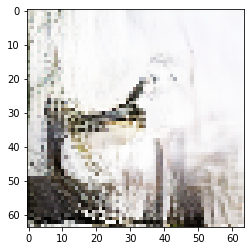

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 17

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 35.30591130256653 sec
Gen loss: 1.5284917884402804, Gen valid loss: 1.4714595693236767, Gen attr loss: 0.05703221799839434, Disc valid loss: 1.0011908747962497, Disc valid real loss: 0.5187492874579701, Disc valid fake loss: 0.48244158701521916, Disc attr loss: 1.7105201712270734, Disc attr real loss: 1.653487953228679, Disc attr fake loss: 0.05703221799839434
Time for epoch 2 is 35.31852912902832 sec
Gen loss: 1.5346855335442355, Gen valid loss: 1.4709257814619277, Gen attr loss: 0.06375975274014901, Disc valid loss: 0.9971944121164358, Disc valid real loss: 0.5154939952904616, Disc valid fake loss: 0.4817004165836789, Disc attr loss: 1.7160643151899275, Disc attr real loss: 1.6523045624497783, Disc attr fake loss: 0.06375975274014901
Time for epoch 3 is 35.305487394332886 sec
Gen loss: 1.5209782501546347, Gen valid loss: 1.457855006220541, Gen attr 

Time for epoch 23 is 35.288140535354614 sec
Gen loss: 1.5173584788149288, Gen valid loss: 1.4550540232399938, Gen attr loss: 0.06230445325456401, Disc valid loss: 1.0071039419510177, Disc valid real loss: 0.5193569751451332, Disc valid fake loss: 0.487746968017361, Disc attr loss: 1.7050576136743898, Disc attr real loss: 1.642753160419826, Disc attr fake loss: 0.06230445325456401
Time for epoch 24 is 35.29794931411743 sec
Gen loss: 1.5231468541835382, Gen valid loss: 1.4618193298820559, Gen attr loss: 0.06132752121983318, Disc valid loss: 0.9971826977846099, Disc valid real loss: 0.5203121232631084, Disc valid fake loss: 0.476870574117676, Disc attr loss: 1.704841024171716, Disc attr real loss: 1.643513502951883, Disc attr fake loss: 0.06132752121983318
Time for epoch 25 is 35.33478379249573 sec
Gen loss: 1.5319804780205415, Gen valid loss: 1.4637209613148758, Gen attr loss: 0.06825951766678029, Disc valid loss: 1.0041607926854597, Disc valid real loss: 0.5236230887533203, Disc valid f

Time for epoch 45 is 35.27058410644531 sec
Gen loss: 1.5019021851583547, Gen valid loss: 1.4497968707950457, Gen attr loss: 0.05210531501895893, Disc valid loss: 1.0025499098023103, Disc valid real loss: 0.520279536079262, Disc valid fake loss: 0.4822703738845784, Disc attr loss: 1.684237283752377, Disc attr real loss: 1.632131968733418, Disc attr fake loss: 0.05210531501895893
Time for epoch 46 is 35.29568004608154 sec
Gen loss: 1.510720659723773, Gen valid loss: 1.4510187014008602, Gen attr loss: 0.05970195631612862, Disc valid loss: 1.0089140308258657, Disc valid real loss: 0.5253498577651615, Disc valid fake loss: 0.48356417419141545, Disc attr loss: 1.694309503013916, Disc attr real loss: 1.6346075466977872, Disc attr fake loss: 0.05970195631612862
Time for epoch 47 is 35.27171540260315 sec
Gen loss: 1.531656320179058, Gen valid loss: 1.4615378654423121, Gen attr loss: 0.0701184538002918, Disc valid loss: 1.001923270503357, Disc valid real loss: 0.5244480524121261, Disc valid fake

Time for epoch 67 is 35.26625847816467 sec
Gen loss: 1.5203683153400576, Gen valid loss: 1.4614245629892118, Gen attr loss: 0.0589437510902506, Disc valid loss: 0.9977659405408513, Disc valid real loss: 0.5160597169463873, Disc valid fake loss: 0.4817062231098733, Disc attr loss: 1.6838931551464067, Disc attr real loss: 1.6249494040561563, Disc attr fake loss: 0.0589437510902506
Time for epoch 68 is 35.28593897819519 sec
Gen loss: 1.5341383057235056, Gen valid loss: 1.4663867236475958, Gen attr loss: 0.06775158327734827, Disc valid loss: 1.0082110911203916, Disc valid real loss: 0.5255365336167457, Disc valid fake loss: 0.48267455645369967, Disc attr loss: 1.6945630677731471, Disc attr real loss: 1.6268114844957988, Disc attr fake loss: 0.06775158327734827
Time for epoch 69 is 35.26637935638428 sec
Gen loss: 1.5185566478305392, Gen valid loss: 1.4621363923478579, Gen attr loss: 0.05642025315318308, Disc valid loss: 1.001705764916531, Disc valid real loss: 0.5168693460584656, Disc valid

Time for epoch 89 is 35.24343776702881 sec
Gen loss: 1.4967333924802662, Gen valid loss: 1.4388113044464814, Gen attr loss: 0.05792208759476429, Disc valid loss: 1.0133819659227925, Disc valid real loss: 0.5244613871341799, Disc valid fake loss: 0.4889205793539683, Disc attr loss: 1.6727883935753434, Disc attr real loss: 1.614866305980579, Disc attr fake loss: 0.05792208759476429
Time for epoch 90 is 35.288771867752075 sec
Gen loss: 1.5030505104762752, Gen valid loss: 1.4478450978028419, Gen attr loss: 0.055205413505305195, Disc valid loss: 1.0094762494570517, Disc valid real loss: 0.5236787822672991, Disc valid fake loss: 0.48579746904734994, Disc attr loss: 1.6706328695947799, Disc attr real loss: 1.6154274560894746, Disc attr fake loss: 0.055205413505305195
Time for epoch 91 is 35.231109857559204 sec
Gen loss: 1.5077890564755696, Gen valid loss: 1.4458620784082388, Gen attr loss: 0.06192697780019334, Disc valid loss: 1.0133380694441032, Disc valid real loss: 0.5256154121260656, Disc

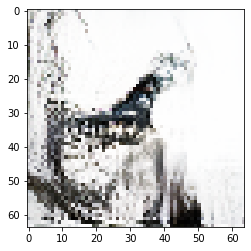

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 18

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 35.22553610801697 sec
Gen loss: 1.5223469995870822, Gen valid loss: 1.460582663050189, Gen attr loss: 0.06176433465542532, Disc valid loss: 1.0019984347064321, Disc valid real loss: 0.5190110256678366, Disc valid fake loss: 0.4829874098462464, Disc attr loss: 1.675044254131146, Disc attr real loss: 1.6132799194757208, Disc attr fake loss: 0.06176433465542532
Time for epoch 2 is 35.20125365257263 sec
Gen loss: 1.5141824193117095, Gen valid loss: 1.4563257170886528, Gen attr loss: 0.057856703703290144, Disc valid loss: 1.0085266717081147, Disc valid real loss: 0.5230449080305694, Disc valid fake loss: 0.48548176335448495, Disc attr loss: 1.6705474238350169, Disc attr real loss: 1.6126907201317269, Disc attr fake loss: 0.057856703703290144
Time for epoch 3 is 35.218384742736816 sec
Gen loss: 1.5189672766662226, Gen valid loss: 1.457524586499222, Gen attr

Time for epoch 23 is 35.23668575286865 sec
Gen loss: 1.5126271735684982, Gen valid loss: 1.4554502127293325, Gen attr loss: 0.05717696069025491, Disc valid loss: 1.012442604474582, Disc valid real loss: 0.5225837276718481, Disc valid fake loss: 0.48985887704502923, Disc attr loss: 1.6575421230705976, Disc attr real loss: 1.6003651623803425, Disc attr fake loss: 0.05717696069025491
Time for epoch 24 is 35.31631588935852 sec
Gen loss: 1.501092157712797, Gen valid loss: 1.443106736271039, Gen attr loss: 0.05798542061318428, Disc valid loss: 1.0095668677392045, Disc valid real loss: 0.5220758714650059, Disc valid fake loss: 0.48749099280129926, Disc attr loss: 1.6621313634394423, Disc attr real loss: 1.604145942826258, Disc attr fake loss: 0.05798542061318428
Time for epoch 25 is 35.27350330352783 sec
Gen loss: 1.5220731965248502, Gen valid loss: 1.464076380096477, Gen attr loss: 0.057996812545170195, Disc valid loss: 1.000700338746151, Disc valid real loss: 0.5164225359919271, Disc valid 

Time for epoch 45 is 35.272263288497925 sec
Gen loss: 1.519195727216519, Gen valid loss: 1.462427016842333, Gen attr loss: 0.05676870780920821, Disc valid loss: 0.9968450297185076, Disc valid real loss: 0.5138712481754583, Disc valid fake loss: 0.4829737838852373, Disc attr loss: 1.6549972499484218, Disc attr real loss: 1.5982285421392135, Disc attr fake loss: 0.05676870780920821
Time for epoch 46 is 35.267178773880005 sec
Gen loss: 1.5109353650230055, Gen valid loss: 1.4527388407285944, Gen attr loss: 0.05819652397094576, Disc valid loss: 1.0184423173992292, Disc valid real loss: 0.526130840303452, Disc valid fake loss: 0.4923114776611328, Disc attr loss: 1.6541598138766385, Disc attr real loss: 1.5959632899056928, Disc attr fake loss: 0.05819652397094576
Time for epoch 47 is 35.261746883392334 sec
Gen loss: 1.5143038729018958, Gen valid loss: 1.451647026105948, Gen attr loss: 0.06265684753050124, Disc valid loss: 1.0002754939603935, Disc valid real loss: 0.5135283340929646, Disc vali

Time for epoch 67 is 35.2725145816803 sec
Gen loss: 1.5128584880492875, Gen valid loss: 1.45262498519608, Gen attr loss: 0.060233500303832996, Disc valid loss: 1.0034227280758907, Disc valid real loss: 0.5217653489532833, Disc valid fake loss: 0.4816573791226074, Disc attr loss: 1.643837822197148, Disc attr real loss: 1.5836043218933147, Disc attr fake loss: 0.060233500303832996
Time for epoch 68 is 35.295591831207275 sec
Gen loss: 1.5158139047260852, Gen valid loss: 1.461380785719812, Gen attr loss: 0.05443311921067164, Disc valid loss: 1.0114411078494416, Disc valid real loss: 0.5253908442772501, Disc valid fake loss: 0.4860502665605002, Disc attr loss: 1.641583836864551, Disc attr real loss: 1.5871507176538793, Disc attr fake loss: 0.05443311921067164
Time for epoch 69 is 35.24988794326782 sec
Gen loss: 1.510603320307848, Gen valid loss: 1.4542652114943113, Gen attr loss: 0.05633810473899189, Disc valid loss: 1.0015807864142627, Disc valid real loss: 0.516632820613339, Disc valid fa

Time for epoch 89 is 35.250590562820435 sec
Gen loss: 1.4980794498267858, Gen valid loss: 1.4395975068332703, Gen attr loss: 0.058481942224889394, Disc valid loss: 1.0053198266481642, Disc valid real loss: 0.5196571519704369, Disc valid fake loss: 0.4856626782313918, Disc attr loss: 1.634804835365005, Disc attr real loss: 1.5763228931401156, Disc attr fake loss: 0.058481942224889394
Time for epoch 90 is 35.197726249694824 sec
Gen loss: 1.5162246456637292, Gen valid loss: 1.4553281527547655, Gen attr loss: 0.0608964942100692, Disc valid loss: 1.0079168811400085, Disc valid real loss: 0.5219637534321162, Disc valid fake loss: 0.48595313005008023, Disc attr loss: 1.63812802365396, Disc attr real loss: 1.5772315294438908, Disc attr fake loss: 0.0608964942100692
Time for epoch 91 is 35.228989124298096 sec
Gen loss: 1.4939447366771337, Gen valid loss: 1.4422523296945464, Gen attr loss: 0.051692404941102846, Disc valid loss: 1.0138581918507088, Disc valid real loss: 0.5246766226563028, Disc v

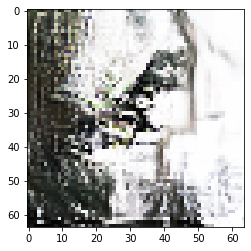

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 19

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 35.26384496688843 sec
Gen loss: 1.5025765249722696, Gen valid loss: 1.4485245574780596, Gen attr loss: 0.05405196747478421, Disc valid loss: 1.012560518776498, Disc valid real loss: 0.5235303533755666, Disc valid fake loss: 0.4890301656432268, Disc attr loss: 1.6304530191033415, Disc attr real loss: 1.5764010516285574, Disc attr fake loss: 0.05405196747478421
Time for epoch 2 is 36.088045597076416 sec
Gen loss: 1.4983027294722353, Gen valid loss: 1.4439975055575693, Gen attr loss: 0.054305223507417566, Disc valid loss: 1.0170890877886516, Disc valid real loss: 0.5307163450776077, Disc valid fake loss: 0.4863727460224131, Disc attr loss: 1.6297713473687665, Disc attr real loss: 1.575466123861349, Disc attr fake loss: 0.054305223507417566
Time for epoch 3 is 35.321253299713135 sec
Gen loss: 1.5152401749680682, Gen valid loss: 1.4553809279025731, Gen att

Time for epoch 23 is 35.1848418712616 sec
Gen loss: 1.4938616251880883, Gen valid loss: 1.4393946752961735, Gen attr loss: 0.05446694722914294, Disc valid loss: 1.018387726005823, Disc valid real loss: 0.5242949321179532, Disc valid fake loss: 0.49409279340327916, Disc attr loss: 1.6230742242464418, Disc attr real loss: 1.5686072770172987, Disc attr fake loss: 0.05446694722914294
Time for epoch 24 is 35.221028089523315 sec
Gen loss: 1.4958494347608509, Gen valid loss: 1.43781457376997, Gen attr loss: 0.05803485723214559, Disc valid loss: 1.0146740988341127, Disc valid real loss: 0.5279606932870095, Disc valid fake loss: 0.4867134057086335, Disc attr loss: 1.6237188480298448, Disc attr real loss: 1.5656839907976994, Disc attr fake loss: 0.05803485723214559
Time for epoch 25 is 35.311415910720825 sec
Gen loss: 1.5027397043982818, Gen valid loss: 1.4483433974790703, Gen attr loss: 0.05439630703639709, Disc valid loss: 1.0047366221745808, Disc valid real loss: 0.5169452888371175, Disc vali

Time for epoch 45 is 35.33597683906555 sec
Gen loss: 1.5021653375651456, Gen valid loss: 1.4473750284370692, Gen attr loss: 0.05479030857241814, Disc valid loss: 1.0059719248838863, Disc valid real loss: 0.5173738984073081, Disc valid fake loss: 0.48859802752652465, Disc attr loss: 1.611725874153908, Disc attr real loss: 1.5569355655814896, Disc attr fake loss: 0.05479030857241814
Time for epoch 46 is 35.38736867904663 sec
Gen loss: 1.5043866369459364, Gen valid loss: 1.4519840255985415, Gen attr loss: 0.05240261214168653, Disc valid loss: 1.0163136143994524, Disc valid real loss: 0.5304655167791579, Disc valid fake loss: 0.48584809778182486, Disc attr loss: 1.608975299153757, Disc attr real loss: 1.5565726870120702, Disc attr fake loss: 0.05240261214168653
Time for epoch 47 is 35.34652328491211 sec
Gen loss: 1.5050109650707504, Gen valid loss: 1.4449278100073175, Gen attr loss: 0.060083153034882944, Disc valid loss: 1.0101369078243327, Disc valid real loss: 0.5243504002972993, Disc va

Time for epoch 67 is 35.22733950614929 sec
Gen loss: 1.4728080816062161, Gen valid loss: 1.4135029002579893, Gen attr loss: 0.05930517977571887, Disc valid loss: 1.0192808460413925, Disc valid real loss: 0.527052108430604, Disc valid fake loss: 0.49222873696466773, Disc attr loss: 1.6100528629919586, Disc attr real loss: 1.5507476832162397, Disc attr fake loss: 0.05930517977571887
Time for epoch 68 is 35.170945167541504 sec
Gen loss: 1.5041539371821293, Gen valid loss: 1.453116515464576, Gen attr loss: 0.051037419975592795, Disc valid loss: 1.0088079179205545, Disc valid real loss: 0.5248535330379559, Disc valid fake loss: 0.48395438730555174, Disc attr loss: 1.6019958233794358, Disc attr real loss: 1.550958403403843, Disc attr fake loss: 0.051037419975592795
Time for epoch 69 is 35.17736268043518 sec
Gen loss: 1.5128853644135845, Gen valid loss: 1.453011860692404, Gen attr loss: 0.05987350150254954, Disc valid loss: 1.0059109847073955, Disc valid real loss: 0.5193600859745409, Disc va

Time for epoch 89 is 35.165090560913086 sec
Gen loss: 1.4801508999129298, Gen valid loss: 1.4279299715993203, Gen attr loss: 0.05222092553170783, Disc valid loss: 1.0134414776877012, Disc valid real loss: 0.5234097703524075, Disc valid fake loss: 0.4900317068507032, Disc attr loss: 1.5948070986771365, Disc attr real loss: 1.5425861731454287, Disc attr fake loss: 0.05222092553170783
Time for epoch 90 is 35.19827365875244 sec
Gen loss: 1.4980201976409127, Gen valid loss: 1.4428187347039945, Gen attr loss: 0.05520146154467039, Disc valid loss: 1.0058965088552252, Disc valid real loss: 0.5185328239024816, Disc valid fake loss: 0.48736368390279733, Disc attr loss: 1.5951266614048272, Disc attr real loss: 1.5399251998601566, Disc attr fake loss: 0.05520146154467039
Time for epoch 91 is 35.219265937805176 sec
Gen loss: 1.4874259834367085, Gen valid loss: 1.4353777196026107, Gen attr loss: 0.0520482616767198, Disc valid loss: 1.0183723933974578, Disc valid real loss: 0.5319533650952626, Disc v

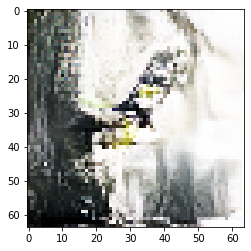

In [301]:
next_starting_checkpoint, totalepochs, warmup = long_train(starting_checkpoint=next_starting_checkpoint, 
                                      num_checkpoints=10, 
                                      checkpoint_interval=100, 
                                      g_hist=gen_loss_hist, 
                                      g_valid_hist=gen_valid_loss_hist,
                                      g_attr_hist=gen_attr_loss_hist,
                                      d_hist=disc_loss_hist,
                                      d_real_hist=disc_loss_real_hist,
                                      d_fake_hist=disc_loss_fake_hist,
                                      d_attr_real_hist=disc_attr_loss_real_hist,
                                      d_attr_fake_hist=disc_attr_loss_fake_hist,
                                      noise=noise100,
                                      attr=attr,
                                      save_files=True,
                                      warmup=warmup)

[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]


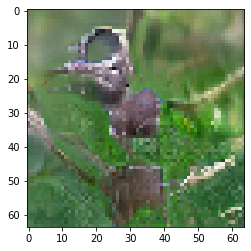

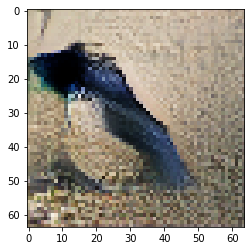

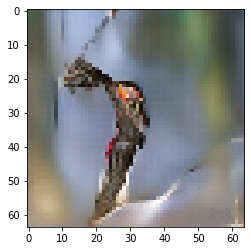

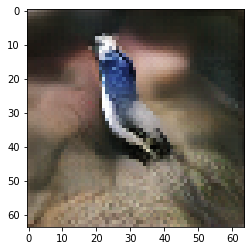

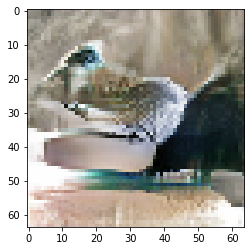

In [437]:
print(attrs)
for i in range(5):
    noise = np.random.normal(0, 1, 100)

    attrs = [0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]
#     attrs[i] = 3
#     attrs[5] -= 1
#     attrs[7] += 1
    generated_image = generator.predict([np.array([noise]), 0*np.array([attrs])] )[0]
    plt.imshow(unnormalize_img(generated_image))
    plt.show()
#     ax.imshow(unnormalize_img(generated_image))

[0.0, 0.0, 0.0, 0.0, 2, 0.0, 0.0, 0.0, 1.0, 0.0]


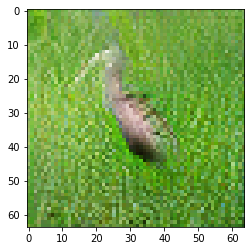

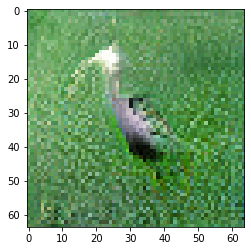

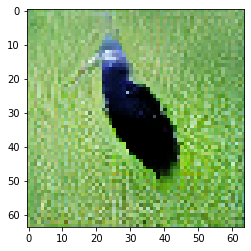

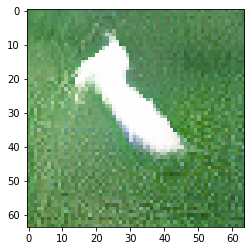

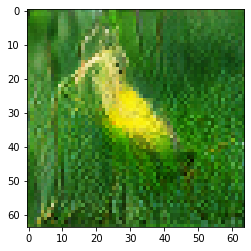

In [428]:

print(attrs)
for i in range(5):
    attrs = [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]
    attrs[i] = 3
#     attrs[5] -= 1
#     attrs[7] += 1
    generated_image = generator.predict([np.array([noise]), np.array([attrs])] )[0]
    plt.imshow(unnormalize_img(generated_image))
    plt.show()
#     ax.imshow(unnormalize_img(generated_image))

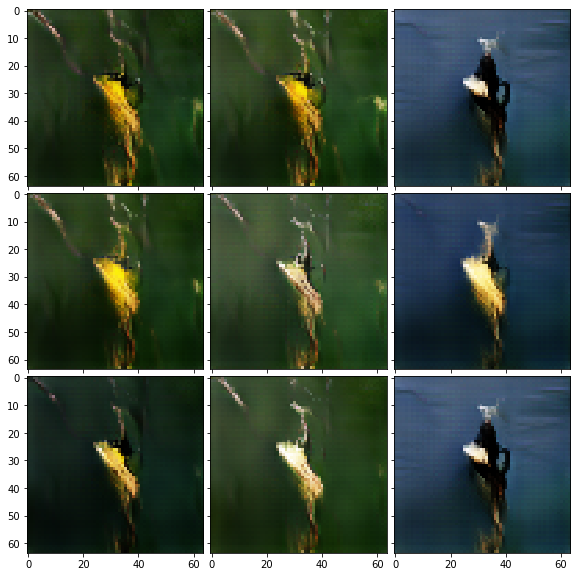

In [310]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

attrs = train_attrs[np.random.choice(range(len(train_attrs)), 9, replace=False)]
noise = np.random.normal(0, 1, 100)
for i, ax in enumerate(grid):
    generated_image = generator.predict([np.array([noise]), np.array([attrs[i]])] )[0]
#     plt.imshow(unnormalize_img(generated_image))
    ax.imshow(unnormalize_img(generated_image))

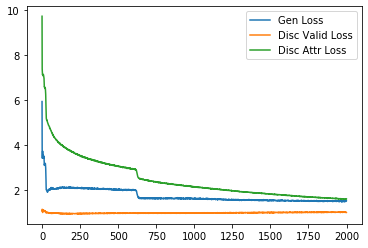

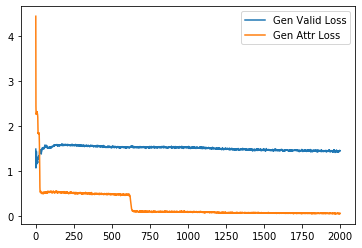

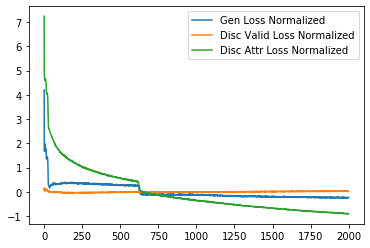

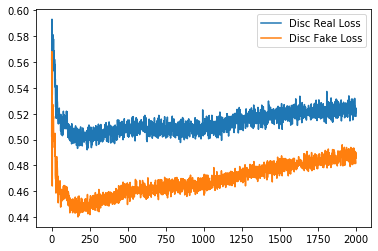

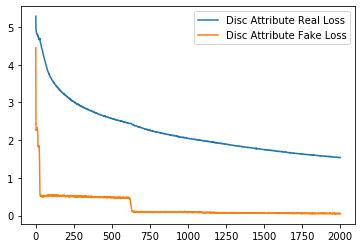

In [306]:
from operator import add
disc_attr_loss_hist = list( map(add, disc_attr_loss_real_hist, disc_attr_loss_fake_hist) )

plt.plot(gen_loss_hist)
plt.plot(disc_loss_hist)
plt.plot(disc_attr_loss_hist)

plt.legend(['Gen Loss','Disc Valid Loss', 'Disc Attr Loss'])
plt.show()

plt.plot(gen_valid_loss_hist)
plt.plot(gen_attr_loss_hist)
plt.legend(['Gen Valid Loss', 'Gen Attr Loss'])
plt.show()

plt.plot(gen_loss_hist - np.mean(gen_loss_hist))
plt.plot(disc_loss_hist - np.mean(disc_loss_hist))
plt.plot(disc_attr_loss_hist - np.mean(disc_attr_loss_hist))
plt.legend(['Gen Loss Normalized','Disc Valid Loss Normalized', 'Disc Attr Loss Normalized'])
plt.show()

plt.plot(disc_loss_real_hist)
plt.plot(disc_loss_fake_hist)
plt.legend(['Disc Real Loss','Disc Fake Loss'])
plt.show()

plt.plot(disc_attr_loss_real_hist)
# plt.show()
plt.plot(disc_attr_loss_fake_hist)
plt.legend(['Disc Attribute Real Loss', 'Disc Attribute Fake Loss'])
plt.show()


In [ ]:
noise = tf.random.truncated_normal([32, 100])
tf.dtypes.cast(noise, tf.int32)


In [364]:
test = tf.random.uniform((32,10), minval=0, maxval=1)
K.mean(test)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5028789>